<a href="https://colab.research.google.com/github/AlexAlexeyuk/AlexAlexeyuk/blob/hf_prediction_h2o/HF_Prediction_H2O.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install h2o
import h2o

     |████████████████████████████████| 129.4MB 83kB/s 
  Created wheel for h2o: filename=h2o-3.30.1.3-py2.py3-none-any.whl size=129446676 sha256=72c5f404aa9ed06ec93f72c5b5cb74ceaf63b6e7def073ecc3c21fce0099ba2f
  Stored in directory: /root/.cache/pip/wheels/3d/e6/07/53ce9be9cb61b33a79cb3ed1fc39f2dae84f6ee6fe1e373e5e
Successfully built h2o


In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpcukc7b1c
  JVM stdout: /tmp/tmpcukc7b1c/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpcukc7b1c/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 24 days
H2O_cluster_name:,H2O_from_python_unknownUser_b3tiyy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [75]:
hf = h2o.import_file('/content/heart_failure_clinical_records_dataset.csv')
hf.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%


age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
75,0,582,0,20,1,265000,1.9,130,1,0,4,1
55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
65,0,146,0,20,0,162000,1.3,129,1,1,7,1
50,1,111,0,20,0,210000,1.9,137,1,0,7,1
65,1,160,1,20,0,327000,2.7,116,0,0,8,1
90,1,47,0,40,1,204000,2.1,132,1,1,8,1
75,1,246,0,15,0,127000,1.2,137,1,0,10,1
60,1,315,1,60,0,454000,1.1,131,1,1,10,1
65,0,157,0,65,0,263358,1.5,138,0,0,10,1
80,1,123,0,35,1,388000,9.4,133,1,1,10,1


In [77]:
# т.к. в наших данных есть параметр "креатинин", для того, чтобы улучшить данные, давайте высчитаем скорость клубочковой
# фильтрации
if hf['sex'].all() > 0:
    if hf['serum_creatinine'].all() < .9:
        hf['GFR'] = 141 * (((hf['serum_creatinine'] / 0.9)) ** (-0.411)) * 0.993 ** hf['age']
    else:
        hf['GFR'] = 141 * (((hf['serum_creatinine'] / 0.9)) ** (-1.209)) * 0.993 ** hf['age']
else:
    if hf['serum_creatinine'].all() < .7:
        hf['GFR'] = 144 * (((hf['serum_creatinine'] / 0.7)) ** (-0.329)) * 0.993 ** hf['age']
    else:
        hf['GFR'] = 144 * (((hf['serum_creatinine'] / 0.7)) ** (-1.209)) * 0.993 ** hf['age']

In [78]:
hf.rename(columns={'age':'возраст',
...                'anaemia':'анемия',
...                 'creatinine_phosphokinase':'креатинфосфокиназа',
...                 'diabetes':'диабет',
...                 'high_blood_pressure':'артериальная гипертензия',
                    'platelets':'тромбоциты',
                    'serum_creatinine':'креатинин сыворотки',
                    'serum_sodium':'натрий',
                    'sex':'пол',
                      'smoking':'курение',
                    'time':'длительнось болезни',
                    'DEATH_EVENT':'Смерть',
                      "GFR":"СКФ",
                      'ejection_fraction':   'фракция выброса'

})


возраст,анемия,креатинфосфокиназа,диабет,фракция выброса,артериальная гипертензия,тромбоциты,креатинин сыворотки,натрий,пол,курение,длительнось болезни,Смерть,СКФ
75,0,582,0,20,1,265000,1.9,130,1,0,4,1,25.4253
55,0,7861,0,38,0,263358,1.1,136,1,0,6,1,56.6567
65,0,146,0,20,0,162000,1.3,129,1,1,7,1,43.1549
50,1,111,0,20,0,210000,1.9,137,1,0,7,1,30.3065
65,1,160,1,20,0,327000,2.7,116,0,0,8,1,17.8348
90,1,47,0,40,1,204000,2.1,132,1,1,8,1,20.2747
75,1,246,0,15,0,127000,1.2,137,1,0,10,1,44.3149
60,1,315,1,60,0,454000,1.1,131,1,1,10,1,54.7012
65,0,157,0,65,0,263358,1.5,138,0,0,10,1,36.2988
80,1,123,0,35,1,388000,9.4,133,1,1,10,1,3.55234


In [79]:
hf.head()

возраст,анемия,креатинфосфокиназа,диабет,фракция выброса,артериальная гипертензия,тромбоциты,креатинин сыворотки,натрий,пол,курение,длительнось болезни,Смерть,СКФ
75,0,582,0,20,1,265000,1.9,130,1,0,4,1,25.4253
55,0,7861,0,38,0,263358,1.1,136,1,0,6,1,56.6567
65,0,146,0,20,0,162000,1.3,129,1,1,7,1,43.1549
50,1,111,0,20,0,210000,1.9,137,1,0,7,1,30.3065
65,1,160,1,20,0,327000,2.7,116,0,0,8,1,17.8348
90,1,47,0,40,1,204000,2.1,132,1,1,8,1,20.2747
75,1,246,0,15,0,127000,1.2,137,1,0,10,1,44.3149
60,1,315,1,60,0,454000,1.1,131,1,1,10,1,54.7012
65,0,157,0,65,0,263358,1.5,138,0,0,10,1,36.2988
80,1,123,0,35,1,388000,9.4,133,1,1,10,1,3.55234


In [80]:
hf_ = hf.drop(['СКФ'], axis=1)

In [81]:
df = hf.drop(['креатинин сыворотки'], axis=1)

In [82]:
df.head()

возраст,анемия,креатинфосфокиназа,диабет,фракция выброса,артериальная гипертензия,тромбоциты,натрий,пол,курение,длительнось болезни,Смерть,СКФ
75,0,582,0,20,1,265000,130,1,0,4,1,25.4253
55,0,7861,0,38,0,263358,136,1,0,6,1,56.6567
65,0,146,0,20,0,162000,129,1,1,7,1,43.1549
50,1,111,0,20,0,210000,137,1,0,7,1,30.3065
65,1,160,1,20,0,327000,116,0,0,8,1,17.8348
90,1,47,0,40,1,204000,132,1,1,8,1,20.2747
75,1,246,0,15,0,127000,137,1,0,10,1,44.3149
60,1,315,1,60,0,454000,131,1,1,10,1,54.7012
65,0,157,0,65,0,263358,138,0,0,10,1,36.2988
80,1,123,0,35,1,388000,133,1,1,10,1,3.55234


In [115]:
df['Смерть'] = df['Смерть'].asfactor()
hf_['Смерть'] = hf_['Смерть'].asfactor()

In [116]:
# Set predictors and response variable
response = "Смерть"
predictors = df.col_names.remove(response)
predictors_ = hf_.col_names.remove(response)

In [117]:
# split
train, test = df.split_frame(seed = 1234, 
                                  ratios = [0.75], 
                                  destination_frames = ["train.hex", "test.hex"])
# split
train_, test_ = hf_.split_frame(seed = 1234, 
                                  ratios = [0.75], 
                                  destination_frames = ["train_.hex", "test_.hex"])

In [118]:
from h2o.estimators.coxph import H2OCoxProportionalHazardsEstimator
train.head()

возраст,анемия,креатинфосфокиназа,диабет,фракция выброса,артериальная гипертензия,тромбоциты,натрий,пол,курение,длительнось болезни,Смерть,СКФ
75,0,582,0,20,1,265000,130,1,0,4,1,25.4253
55,0,7861,0,38,0,263358,136,1,0,6,1,56.6567
65,0,146,0,20,0,162000,129,1,1,7,1,43.1549
65,1,160,1,20,0,327000,116,0,0,8,1,17.8348
90,1,47,0,40,1,204000,132,1,1,8,1,20.2747
75,1,246,0,15,0,127000,137,1,0,10,1,44.3149
60,1,315,1,60,0,454000,131,1,1,10,1,54.7012
65,0,157,0,65,0,263358,138,0,0,10,1,36.2988
75,1,81,0,38,1,368000,131,1,1,10,1,10.3369
62,0,231,0,25,1,253000,140,1,1,10,1,68.748


In [119]:
# Build and train the model:
heart_coxph = H2OCoxProportionalHazardsEstimator(stop_column='длительнось болезни'
                                                 )
heart_coxph.train(x=predictors_,
            y=response, training_frame = train_)

# Generate predictions on a test set (if necessary):
#pred = heart_coxph.predict(test)

coxph Model Build progress: |█████████████████████████████████████████████| 100%


In [120]:
pred = heart_coxph.predict(test)

coxph prediction progress: |██████████████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/h2o/job.py:70: UserWarning: Test/Validation dataset is missing column 'креатинин сыворотки': substituting in a column of NaN
  warnings.warn(w)


In [126]:
heart_coxph.model_performance

Model Details
H2OCoxProportionalHazardsEstimator :  Cox Proportional Hazards
Model Key:  CoxPH_model_python_1606045360681_11358

Call: 
Surv(длительнось болезни, Смерть) ~ возраст + анемия + креатинфосфокиназа + диабет + фракция выброса + артериальная гипертензия + тромбоциты + креатинин сыворотки + натрий + пол + курение

Coefficients: CoxPH Coefficients


,names,coefficients,exp_coef,exp_neg_coef,se_coef,z_coef
0,возраст,4.882680e-02,1.050038,0.952346,0.011133,4.385716
1,анемия,3.939858e-01,1.482880,0.674364,0.248252,1.587039
2,креатинфосфокиназа,2.274959e-04,1.000228,0.999773,0.000119,1.909934
3,диабет,2.003070e-01,1.221778,0.818479,0.261245,0.766739
4,фракция выброса,-4.224301e-02,0.958637,1.043148,0.011425,-3.697529
5,артериальная гипертензия,2.814457e-01,1.325044,0.754692,0.252480,1.114726
6,тромбоциты,2.463114e-07,1.000000,1.000000,0.000001,0.186524
7,креатинин сыворотки,3.859623e-01,1.471029,0.679796,0.087318,4.420186
8,натрий,-2.918476e-02,0.971237,1.029615,0.024837,-1.175061
9,пол,7.043709e-02,1.072977,0.931986,0.301276,0.233796



Likelihood ratio test=58.211668
n=227, number of events=73

Scoring History: 


,,timestamp,duration,iterations,loglik
0,,2020-11-22 14:35:06,0.000 sec,0,-364.243116
1,,2020-11-22 14:35:06,0.008 sec,1,-340.485801
2,,2020-11-22 14:35:06,0.010 sec,2,-335.570740
3,,2020-11-22 14:35:06,0.014 sec,3,-335.147977
4,,2020-11-22 14:35:06,0.016 sec,4,-335.137293
5,,2020-11-22 14:35:06,0.022 sec,5,-335.137283


<bound method ModelBase.model_performance of >

In [128]:
heart_coxph.predict(test_)

coxph prediction progress: |██████████████████████████████████████████████| 100%


lp
0.384298
4.58582
-0.206104
-0.0367618
0.935543
-0.518181
0.88775
1.04428
1.56788
1.2255


In [94]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

#We only provide the required parameters, everything else is default
gbm_model = H2OGradientBoostingEstimator(seed = 1234, nfolds = 5)
gbm_model.train(x = predictors
                , y = response
                , training_frame = train
                , validation_frame = test
                , model_id = "gbm_default.hex"
               )

## Show a detailed model summary
print(gbm_model)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_default.hex


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,10388.0,5.0,5.0,5.0,10.0,15.0,11.94




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.011946144967970116
RMSE: 0.109298421617012
LogLoss: 0.07662129283688611
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49755511518829654: 


,,0,1,Error,Rate
0,0,154.0,0.0,0.0,(0.0/154.0)
1,1,0.0,73.0,0.0,(0.0/73.0)
2,Total,154.0,73.0,0.0,(0.0/227.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.497555,1.000000,72.0
1,max f2,0.497555,1.000000,72.0
2,max f0point5,0.497555,1.000000,72.0
3,max accuracy,0.497555,1.000000,72.0
4,max precision,0.991612,1.000000,0.0
5,max recall,0.497555,1.000000,72.0
6,max specificity,0.991612,1.000000,0.0
7,max absolute_mcc,0.497555,1.000000,72.0
8,max min_per_class_accuracy,0.497555,1.000000,72.0
9,max mean_per_class_accuracy,0.497555,1.000000,72.0



Gains/Lift Table: Avg response rate: 32.16 %, avg score: 32.19 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.013216,0.988280,3.109589,3.109589,1.000000,0.990093,1.000000,0.990093,0.041096,0.041096,210.958904,210.958904,0.041096
1,2,0.022026,0.982140,3.109589,3.109589,1.000000,0.984563,1.000000,0.987881,0.027397,0.068493,210.958904,210.958904,0.068493
2,3,0.030837,0.979775,3.109589,3.109589,1.000000,0.980579,1.000000,0.985794,0.027397,0.095890,210.958904,210.958904,0.095890
3,4,0.044053,0.978055,3.109589,3.109589,1.000000,0.978950,1.000000,0.983741,0.041096,0.136986,210.958904,210.958904,0.136986
4,5,0.052863,0.974306,3.109589,3.109589,1.000000,0.974898,1.000000,0.982267,0.027397,0.164384,210.958904,210.958904,0.164384
5,6,0.101322,0.959149,3.109589,3.109589,1.000000,0.966368,1.000000,0.974663,0.150685,0.315068,210.958904,210.958904,0.315068
6,7,0.149780,0.925778,3.109589,3.109589,1.000000,0.951754,1.000000,0.967251,0.150685,0.465753,210.958904,210.958904,0.465753
7,8,0.202643,0.895965,3.109589,3.109589,1.000000,0.911514,1.000000,0.952711,0.164384,0.630137,210.958904,210.958904,0.630137
8,9,0.299559,0.709774,3.109589,3.109589,1.000000,0.827263,1.000000,0.912125,0.301370,0.931507,210.958904,210.958904,0.931507
9,10,0.400881,0.115470,0.675998,2.494505,0.217391,0.298713,0.802198,0.757087,0.068493,1.000000,-32.400238,149.450549,0.883117




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.10532530029270998
RMSE: 0.3245385959985499
LogLoss: 0.3389902726664774
Mean Per-Class Error: 0.12511091393078977
AUC: 0.9396628216503993
AUCPR: 0.8703783142397495
Gini: 0.8793256433007985

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5436872313466118: 


,,0,1,Error,Rate
0,0,43.0,6.0,0.1224,(6.0/49.0)
1,1,3.0,20.0,0.1304,(3.0/23.0)
2,Total,46.0,26.0,0.125,(9.0/72.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.543687,0.816327,25.0
1,max f2,0.162039,0.891473,36.0
2,max f0point5,0.877183,0.842105,17.0
3,max accuracy,0.877183,0.875000,17.0
4,max precision,0.987770,1.000000,0.0
5,max recall,0.162039,1.000000,36.0
6,max specificity,0.987770,1.000000,0.0
7,max absolute_mcc,0.543687,0.725245,25.0
8,max min_per_class_accuracy,0.543687,0.869565,25.0
9,max mean_per_class_accuracy,0.438297,0.874889,28.0



Gains/Lift Table: Avg response rate: 31.94 %, avg score: 39.34 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.013889,0.985535,3.130435,3.130435,1.000000,0.987770,1.000000,0.987770,0.043478,0.043478,213.043478,213.043478,0.043478
1,2,0.027778,0.982053,3.130435,3.130435,1.000000,0.984623,1.000000,0.986196,0.043478,0.086957,213.043478,213.043478,0.086957
2,3,0.041667,0.978502,3.130435,3.130435,1.000000,0.978505,1.000000,0.983632,0.043478,0.130435,213.043478,213.043478,0.130435
3,4,0.041667,0.978489,0.000000,3.130435,0.000000,0.000000,1.000000,0.983632,0.000000,0.130435,-100.000000,213.043478,0.130435
4,5,0.055556,0.978463,3.130435,3.130435,1.000000,0.978486,1.000000,0.982346,0.043478,0.173913,213.043478,213.043478,0.173913
5,6,0.111111,0.974078,2.347826,2.739130,0.750000,0.976650,0.875000,0.979498,0.130435,0.304348,134.782609,173.913043,0.283940
6,7,0.152778,0.958805,3.130435,2.845850,1.000000,0.965580,0.909091,0.975702,0.130435,0.434783,213.043478,184.584980,0.414374
7,8,0.208333,0.930688,2.347826,2.713043,0.750000,0.942145,0.866667,0.966754,0.130435,0.565217,134.782609,171.304348,0.524401
8,9,0.305556,0.758493,2.236025,2.561265,0.714286,0.857309,0.818182,0.931930,0.217391,0.782609,123.602484,156.126482,0.700976
9,10,0.402778,0.421597,1.341615,2.266867,0.428571,0.594744,0.724138,0.850540,0.130435,0.913043,34.161491,126.686657,0.749778




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.12531847384644515
RMSE: 0.35400349411615295
LogLoss: 0.39966645123442596
Mean Per-Class Error: 0.16518413093755557
AUC: 0.8980608432663226
AUCPR: 0.8001218303143101
Gini: 0.7961216865326453

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16073695161630783: 


,,0,1,Error,Rate
0,0,120.0,34.0,0.2208,(34.0/154.0)
1,1,8.0,65.0,0.1096,(8.0/73.0)
2,Total,128.0,99.0,0.185,(42.0/227.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.160737,0.755814,98.0
1,max f2,0.131518,0.841709,105.0
2,max f0point5,0.839911,0.775510,42.0
3,max accuracy,0.435333,0.841410,68.0
4,max precision,0.994021,1.000000,0.0
5,max recall,0.012384,1.000000,194.0
6,max specificity,0.994021,1.000000,0.0
7,max absolute_mcc,0.435333,0.631758,68.0
8,max min_per_class_accuracy,0.228814,0.818182,87.0
9,max mean_per_class_accuracy,0.160737,0.834816,98.0



Gains/Lift Table: Avg response rate: 32.16 %, avg score: 31.13 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.013216,0.985917,3.109589,3.109589,1.000000,0.990951,1.000000,0.990951,0.041096,0.041096,210.958904,210.958904,0.041096
1,2,0.022026,0.983802,3.109589,3.109589,1.000000,0.985060,1.000000,0.988594,0.027397,0.068493,210.958904,210.958904,0.068493
2,3,0.030837,0.975225,3.109589,3.109589,1.000000,0.981917,1.000000,0.986687,0.027397,0.095890,210.958904,210.958904,0.095890
3,4,0.044053,0.972514,2.073059,2.798630,0.666667,0.973113,0.900000,0.982615,0.027397,0.123288,107.305936,179.863014,0.116794
4,5,0.052863,0.964096,1.554795,2.591324,0.500000,0.966470,0.833333,0.979924,0.013699,0.136986,55.479452,159.132420,0.123999
5,6,0.101322,0.937305,2.826899,2.703990,0.909091,0.948059,0.869565,0.964684,0.136986,0.273973,182.689913,170.399047,0.254492
6,7,0.149780,0.896937,2.544209,2.652297,0.818182,0.914410,0.852941,0.948419,0.123288,0.397260,154.420922,165.229654,0.364793
7,8,0.202643,0.822437,2.332192,2.568791,0.750000,0.863942,0.826087,0.926381,0.123288,0.520548,133.219178,156.879095,0.468600
8,9,0.299559,0.437273,1.978829,2.377921,0.636364,0.641030,0.764706,0.834062,0.191781,0.712329,97.882939,137.792103,0.608433
9,10,0.400881,0.204354,1.216796,2.084450,0.391304,0.320515,0.670330,0.704264,0.123288,0.835616,21.679571,108.444980,0.640811




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.88713133,0.045035534,0.90909094,0.9318182,0.82,0.9111111,0.8636364
1,auc,0.91893935,0.040876687,0.9281046,0.9764706,0.8915441,0.92901236,0.8695652
2,aucpr,0.8424718,0.060477402,0.8687531,0.92881167,0.77060413,0.80645216,0.8377379
3,err,0.11286869,0.045035534,0.09090909,0.06818182,0.18,0.08888889,0.13636364
4,err_count,5.2,2.3874674,4.0,3.0,9.0,4.0,6.0
5,f0point5,0.8027624,0.06647298,0.88235295,0.8064516,0.70652175,0.7777778,0.84070796
6,f1,0.8272379,0.06269078,0.88235295,0.8695652,0.74285716,0.7777778,0.8636364
7,f2,0.85490197,0.07205794,0.88235295,0.9433962,0.78313255,0.7777778,0.88785046
8,lift_top_group,3.4416947,1.22355,2.5882354,4.4,3.125,5.0,2.0952382
9,logloss,0.39898258,0.15390427,0.34963903,0.22303621,0.4330467,0.34983677,0.6393542



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-11-22 14:09:42,2.172 sec,0.0,0.467085,0.628059,0.500000,0.321586,1.000000,0.678414,0.466266,0.626461,0.500000,0.319444,1.000000,0.680556
1,,2020-11-22 14:09:42,2.186 sec,1.0,0.439071,0.571070,0.940002,0.901064,3.109589,0.127753,0.439804,0.572763,0.897959,0.747911,2.459627,0.138889
2,,2020-11-22 14:09:42,2.200 sec,2.0,0.415482,0.526600,0.943960,0.902814,3.109589,0.127753,0.418647,0.532952,0.898846,0.748421,2.459627,0.138889
3,,2020-11-22 14:09:42,2.208 sec,3.0,0.393736,0.487260,0.953256,0.914439,3.109589,0.118943,0.400227,0.499369,0.907720,0.755664,2.459627,0.138889
4,,2020-11-22 14:09:42,2.215 sec,4.0,0.375302,0.454793,0.955035,0.914906,3.109589,0.105727,0.385564,0.472786,0.913043,0.760215,2.459627,0.138889
5,,2020-11-22 14:09:42,2.223 sec,5.0,0.358614,0.425775,0.960238,0.924276,3.109589,0.088106,0.373598,0.450934,0.906389,0.705443,1.565217,0.125000
6,,2020-11-22 14:09:42,2.232 sec,6.0,0.343409,0.399896,0.964864,0.931851,3.109589,0.088106,0.364833,0.434023,0.908163,0.712485,1.565217,0.125000
7,,2020-11-22 14:09:42,2.240 sec,7.0,0.330595,0.377709,0.965931,0.932277,3.109589,0.083700,0.357760,0.420193,0.905501,0.709123,1.565217,0.138889
8,,2020-11-22 14:09:42,2.248 sec,8.0,0.319957,0.359305,0.967755,0.936158,3.109589,0.079295,0.349114,0.404339,0.916149,0.736666,1.565217,0.111111
9,,2020-11-22 14:09:42,2.256 sec,9.0,0.310958,0.343569,0.968555,0.938410,3.109589,0.079295,0.345571,0.396091,0.914374,0.733001,0.000000,0.125000



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,длительнось болезни,123.277771,1.000000,0.545457
1,СКФ,44.535057,0.361258,0.197051
2,фракция выброса,19.506405,0.158231,0.086308
3,креатинфосфокиназа,12.753557,0.103454,0.056430
4,возраст,9.163221,0.074330,0.040544
5,тромбоциты,7.960716,0.064575,0.035223
6,натрий,2.545994,0.020652,0.011265
7,диабет,1.899512,0.015408,0.008405
8,пол,1.848656,0.014996,0.008180
9,курение,1.588477,0.012885,0.007028


In [95]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

#We only provide the required parameters, everything else is default
gbm_model_ = H2OGradientBoostingEstimator(seed = 1234, nfolds = 5)
gbm_model_.train(x = predictors_
                , y = response
                , training_frame = train_
                , validation_frame = test_
                , model_id = "gbm_default_.hex"
               )

## Show a detailed model summary
print(gbm_model_)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_default_.hex


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,10281.0,5.0,5.0,5.0,8.0,16.0,11.76




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.013428331268414168
RMSE: 0.11588067685517792
LogLoss: 0.0807261736180601
Mean Per-Class Error: 0.0032467532467532756
AUC: 0.9999110478562533
AUCPR: 0.9998136212047154
Gini: 0.9998220957125066

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.449060590734057: 


,,0,1,Error,Rate
0,0,153.0,1.0,0.0065,(1.0/154.0)
1,1,0.0,73.0,0.0,(0.0/73.0)
2,Total,153.0,74.0,0.0044,(1.0/227.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.449061,0.993197,73.0
1,max f2,0.449061,0.997268,73.0
2,max f0point5,0.494823,0.997230,71.0
3,max accuracy,0.494823,0.995595,71.0
4,max precision,0.990803,1.000000,0.0
5,max recall,0.449061,1.000000,73.0
6,max specificity,0.990803,1.000000,0.0
7,max absolute_mcc,0.449061,0.989990,73.0
8,max min_per_class_accuracy,0.449061,0.993506,73.0
9,max mean_per_class_accuracy,0.449061,0.996753,73.0



Gains/Lift Table: Avg response rate: 32.16 %, avg score: 32.18 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.013216,0.983119,3.109589,3.109589,1.000000,0.988047,1.000000,0.988047,0.041096,0.041096,210.958904,210.958904,0.041096
1,2,0.022026,0.981513,3.109589,3.109589,1.000000,0.982802,1.000000,0.985949,0.027397,0.068493,210.958904,210.958904,0.068493
2,3,0.030837,0.979312,3.109589,3.109589,1.000000,0.979899,1.000000,0.984221,0.027397,0.095890,210.958904,210.958904,0.095890
3,4,0.044053,0.977862,3.109589,3.109589,1.000000,0.978463,1.000000,0.982493,0.041096,0.136986,210.958904,210.958904,0.136986
4,5,0.052863,0.976329,3.109589,3.109589,1.000000,0.977208,1.000000,0.981613,0.027397,0.164384,210.958904,210.958904,0.164384
5,6,0.101322,0.960209,3.109589,3.109589,1.000000,0.967892,1.000000,0.975050,0.150685,0.315068,210.958904,210.958904,0.315068
6,7,0.149780,0.941558,3.109589,3.109589,1.000000,0.952466,1.000000,0.967744,0.150685,0.465753,210.958904,210.958904,0.465753
7,8,0.202643,0.881073,3.109589,3.109589,1.000000,0.909985,1.000000,0.952676,0.164384,0.630137,210.958904,210.958904,0.630137
8,9,0.299559,0.718557,3.109589,3.109589,1.000000,0.818246,1.000000,0.909184,0.301370,0.931507,210.958904,210.958904,0.931507
9,10,0.400881,0.102416,0.675998,2.494505,0.217391,0.307226,0.802198,0.757041,0.068493,1.000000,-32.400238,149.450549,0.883117




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.11875881673377825
RMSE: 0.34461401122673213
LogLoss: 0.3671383259517132
Mean Per-Class Error: 0.13531499556344273
AUC: 0.9201419698314108
AUCPR: 0.8416488442462239
Gini: 0.8402839396628217

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.520923666105577: 


,,0,1,Error,Rate
0,0,40.0,9.0,0.1837,(9.0/49.0)
1,1,2.0,21.0,0.087,(2.0/23.0)
2,Total,42.0,30.0,0.1528,(11.0/72.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.520924,0.792453,29.0
1,max f2,0.181458,0.877863,38.0
2,max f0point5,0.911055,0.804598,15.0
3,max accuracy,0.911055,0.847222,15.0
4,max precision,0.986530,1.000000,0.0
5,max recall,0.181458,1.000000,38.0
6,max specificity,0.986530,1.000000,0.0
7,max absolute_mcc,0.520924,0.689802,29.0
8,max min_per_class_accuracy,0.594579,0.836735,27.0
9,max mean_per_class_accuracy,0.520924,0.864685,29.0



Gains/Lift Table: Avg response rate: 31.94 %, avg score: 39.79 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.013889,0.981670,3.130435,3.130435,1.000000,0.986530,1.000000,0.986530,0.043478,0.043478,213.043478,213.043478,0.043478
1,2,0.027778,0.979253,3.130435,3.130435,1.000000,0.979685,1.000000,0.983107,0.043478,0.086957,213.043478,213.043478,0.086957
2,3,0.041667,0.977566,3.130435,3.130435,1.000000,0.978657,1.000000,0.981624,0.043478,0.130435,213.043478,213.043478,0.130435
3,4,0.041667,0.971609,0.000000,3.130435,0.000000,0.000000,1.000000,0.981624,0.000000,0.130435,-100.000000,213.043478,0.130435
4,5,0.055556,0.970228,3.130435,3.130435,1.000000,0.970267,1.000000,0.978785,0.043478,0.173913,213.043478,213.043478,0.173913
5,6,0.111111,0.962794,3.130435,3.130435,1.000000,0.966264,1.000000,0.972524,0.173913,0.347826,213.043478,213.043478,0.347826
6,7,0.152778,0.946626,1.043478,2.561265,0.333333,0.954609,0.818182,0.967638,0.043478,0.391304,4.347826,156.126482,0.350488
7,8,0.208333,0.920887,3.130435,2.713043,1.000000,0.937775,0.866667,0.959675,0.173913,0.565217,213.043478,171.304348,0.524401
8,9,0.305556,0.731494,1.788820,2.418972,0.571429,0.822083,0.772727,0.915896,0.173913,0.739130,78.881988,141.897233,0.637090
9,10,0.402778,0.524233,1.341615,2.158921,0.428571,0.637387,0.689655,0.848670,0.130435,0.869565,34.161491,115.892054,0.685892




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.12821967307272464
RMSE: 0.3580777472459363
LogLoss: 0.4076602956505638
Mean Per-Class Error: 0.171677637431062
AUC: 0.8911225760540828
AUCPR: 0.7778299498128229
Gini: 0.7822451521081657

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17234253973451227: 


,,0,1,Error,Rate
0,0,120.0,34.0,0.2208,(34.0/154.0)
1,1,9.0,64.0,0.1233,(9.0/73.0)
2,Total,129.0,98.0,0.1894,(43.0/227.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.172343,0.748538,97.0
1,max f2,0.121154,0.837500,107.0
2,max f0point5,0.795971,0.778210,45.0
3,max accuracy,0.795971,0.828194,45.0
4,max precision,0.993914,1.000000,0.0
5,max recall,0.009859,1.000000,205.0
6,max specificity,0.993914,1.000000,0.0
7,max absolute_mcc,0.172343,0.618548,97.0
8,max min_per_class_accuracy,0.296692,0.808219,85.0
9,max mean_per_class_accuracy,0.165169,0.828322,100.0



Gains/Lift Table: Avg response rate: 32.16 %, avg score: 31.38 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.013216,0.985342,2.073059,2.073059,0.666667,0.988458,0.666667,0.988458,0.027397,0.027397,107.305936,107.305936,0.020904
1,2,0.022026,0.983104,3.109589,2.487671,1.000000,0.984078,0.800000,0.986706,0.027397,0.054795,210.958904,148.767123,0.048301
2,3,0.030837,0.979856,3.109589,2.665362,1.000000,0.982058,0.857143,0.985378,0.027397,0.082192,210.958904,166.536204,0.075698
3,4,0.044053,0.968525,3.109589,2.798630,1.000000,0.974484,0.900000,0.982110,0.041096,0.123288,210.958904,179.863014,0.116794
4,5,0.052863,0.964085,3.109589,2.850457,1.000000,0.965230,0.916667,0.979296,0.027397,0.150685,210.958904,185.045662,0.144191
5,6,0.101322,0.930905,2.544209,2.703990,0.818182,0.948263,0.869565,0.964454,0.123288,0.273973,154.420922,170.399047,0.254492
6,7,0.149780,0.882422,2.544209,2.652297,0.818182,0.914911,0.852941,0.948426,0.123288,0.397260,154.420922,165.229654,0.364793
7,8,0.202643,0.795712,2.850457,2.703990,0.916667,0.843387,0.869565,0.921024,0.150685,0.547945,185.045662,170.399047,0.508984
8,9,0.299559,0.433226,1.413450,2.286463,0.454545,0.619087,0.735294,0.823339,0.136986,0.684932,41.344956,128.646253,0.568048
9,10,0.400881,0.232008,1.487195,2.084450,0.478261,0.344872,0.670330,0.702408,0.150685,0.835616,48.719476,108.444980,0.640811




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.8950303,0.035736125,0.8863636,0.9318182,0.86,0.93333334,0.8636364
1,auc,0.9132007,0.04046534,0.91938996,0.9705882,0.89705884,0.9197531,0.85921323
2,aucpr,0.8277346,0.072603196,0.8749114,0.90145445,0.7122008,0.8194771,0.8306292
3,err,0.104969695,0.035736125,0.11363637,0.06818182,0.14,0.06666667,0.13636364
4,err_count,4.8,1.7888544,5.0,3.0,7.0,3.0,6.0
5,f0point5,0.8288412,0.03161233,0.8426966,0.8333333,0.77380955,0.85365856,0.84070796
6,f1,0.83786607,0.032060742,0.85714287,0.85714287,0.7878788,0.8235294,0.8636364
7,f2,0.84804404,0.04522923,0.872093,0.88235295,0.80246913,0.79545456,0.88785046
8,lift_top_group,2.8166947,1.9862112,2.5882354,4.4,0.0,5.0,2.0952382
9,logloss,0.40794286,0.14764045,0.37251565,0.26717097,0.40924636,0.33598074,0.6548006



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-11-22 14:09:48,2.403 sec,0.0,0.467085,0.628059,0.500000,0.321586,1.000000,0.678414,0.466266,0.626461,0.500000,0.319444,1.000000,0.680556
1,,2020-11-22 14:09:48,2.415 sec,1.0,0.440706,0.574249,0.928260,0.882661,3.109589,0.149780,0.441025,0.575137,0.889086,0.728391,2.347826,0.138889
2,,2020-11-22 14:09:48,2.426 sec,2.0,0.418455,0.531970,0.931107,0.887268,3.109589,0.145374,0.421053,0.537319,0.889973,0.729715,2.347826,0.138889
3,,2020-11-22 14:09:48,2.438 sec,3.0,0.397599,0.493956,0.948764,0.907619,3.109589,0.123348,0.403141,0.504310,0.909494,0.768589,2.504348,0.152778
4,,2020-11-22 14:09:48,2.446 sec,4.0,0.380846,0.464297,0.948319,0.907943,3.109589,0.123348,0.390769,0.481828,0.905945,0.735460,1.565217,0.138889
5,,2020-11-22 14:09:48,2.455 sec,5.0,0.365189,0.436950,0.954946,0.917568,3.109589,0.110132,0.380401,0.462371,0.899734,0.713263,1.565217,0.152778
6,,2020-11-22 14:09:48,2.469 sec,6.0,0.350310,0.411461,0.962284,0.929709,3.109589,0.088106,0.371008,0.444811,0.904170,0.712245,0.000000,0.125000
7,,2020-11-22 14:09:48,2.479 sec,7.0,0.338647,0.391072,0.961128,0.926259,3.109589,0.096916,0.364305,0.431250,0.905058,0.710563,0.000000,0.138889
8,,2020-11-22 14:09:48,2.494 sec,8.0,0.328431,0.373264,0.963663,0.931570,3.109589,0.088106,0.358493,0.420101,0.907720,0.715202,0.000000,0.125000
9,,2020-11-22 14:09:48,2.503 sec,9.0,0.319232,0.356884,0.964108,0.931951,3.109589,0.088106,0.354893,0.411537,0.905058,0.710563,0.000000,0.138889



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,длительнось болезни,122.979134,1.000000,0.549736
1,креатинин сыворотки,32.962624,0.268034,0.147348
2,фракция выброса,20.028009,0.162857,0.089528
3,креатинфосфокиназа,16.040195,0.130430,0.071702
4,тромбоциты,12.106414,0.098443,0.054118
5,возраст,12.060048,0.098066,0.053910
6,натрий,3.632334,0.029536,0.016237
7,пол,1.189704,0.009674,0.005318
8,диабет,1.021446,0.008306,0.004566
9,курение,0.769368,0.006256,0.003439


In [96]:
gbm_model.auc

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_default.hex


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,10388.0,5.0,5.0,5.0,10.0,15.0,11.94




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.011946144967970116
RMSE: 0.109298421617012
LogLoss: 0.07662129283688611
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49755511518829654: 


,,0,1,Error,Rate
0,0,154.0,0.0,0.0,(0.0/154.0)
1,1,0.0,73.0,0.0,(0.0/73.0)
2,Total,154.0,73.0,0.0,(0.0/227.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.497555,1.000000,72.0
1,max f2,0.497555,1.000000,72.0
2,max f0point5,0.497555,1.000000,72.0
3,max accuracy,0.497555,1.000000,72.0
4,max precision,0.991612,1.000000,0.0
5,max recall,0.497555,1.000000,72.0
6,max specificity,0.991612,1.000000,0.0
7,max absolute_mcc,0.497555,1.000000,72.0
8,max min_per_class_accuracy,0.497555,1.000000,72.0
9,max mean_per_class_accuracy,0.497555,1.000000,72.0



Gains/Lift Table: Avg response rate: 32.16 %, avg score: 32.19 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.013216,0.988280,3.109589,3.109589,1.000000,0.990093,1.000000,0.990093,0.041096,0.041096,210.958904,210.958904,0.041096
1,2,0.022026,0.982140,3.109589,3.109589,1.000000,0.984563,1.000000,0.987881,0.027397,0.068493,210.958904,210.958904,0.068493
2,3,0.030837,0.979775,3.109589,3.109589,1.000000,0.980579,1.000000,0.985794,0.027397,0.095890,210.958904,210.958904,0.095890
3,4,0.044053,0.978055,3.109589,3.109589,1.000000,0.978950,1.000000,0.983741,0.041096,0.136986,210.958904,210.958904,0.136986
4,5,0.052863,0.974306,3.109589,3.109589,1.000000,0.974898,1.000000,0.982267,0.027397,0.164384,210.958904,210.958904,0.164384
5,6,0.101322,0.959149,3.109589,3.109589,1.000000,0.966368,1.000000,0.974663,0.150685,0.315068,210.958904,210.958904,0.315068
6,7,0.149780,0.925778,3.109589,3.109589,1.000000,0.951754,1.000000,0.967251,0.150685,0.465753,210.958904,210.958904,0.465753
7,8,0.202643,0.895965,3.109589,3.109589,1.000000,0.911514,1.000000,0.952711,0.164384,0.630137,210.958904,210.958904,0.630137
8,9,0.299559,0.709774,3.109589,3.109589,1.000000,0.827263,1.000000,0.912125,0.301370,0.931507,210.958904,210.958904,0.931507
9,10,0.400881,0.115470,0.675998,2.494505,0.217391,0.298713,0.802198,0.757087,0.068493,1.000000,-32.400238,149.450549,0.883117




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.10532530029270998
RMSE: 0.3245385959985499
LogLoss: 0.3389902726664774
Mean Per-Class Error: 0.12511091393078977
AUC: 0.9396628216503993
AUCPR: 0.8703783142397495
Gini: 0.8793256433007985

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5436872313466118: 


,,0,1,Error,Rate
0,0,43.0,6.0,0.1224,(6.0/49.0)
1,1,3.0,20.0,0.1304,(3.0/23.0)
2,Total,46.0,26.0,0.125,(9.0/72.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.543687,0.816327,25.0
1,max f2,0.162039,0.891473,36.0
2,max f0point5,0.877183,0.842105,17.0
3,max accuracy,0.877183,0.875000,17.0
4,max precision,0.987770,1.000000,0.0
5,max recall,0.162039,1.000000,36.0
6,max specificity,0.987770,1.000000,0.0
7,max absolute_mcc,0.543687,0.725245,25.0
8,max min_per_class_accuracy,0.543687,0.869565,25.0
9,max mean_per_class_accuracy,0.438297,0.874889,28.0



Gains/Lift Table: Avg response rate: 31.94 %, avg score: 39.34 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.013889,0.985535,3.130435,3.130435,1.000000,0.987770,1.000000,0.987770,0.043478,0.043478,213.043478,213.043478,0.043478
1,2,0.027778,0.982053,3.130435,3.130435,1.000000,0.984623,1.000000,0.986196,0.043478,0.086957,213.043478,213.043478,0.086957
2,3,0.041667,0.978502,3.130435,3.130435,1.000000,0.978505,1.000000,0.983632,0.043478,0.130435,213.043478,213.043478,0.130435
3,4,0.041667,0.978489,0.000000,3.130435,0.000000,0.000000,1.000000,0.983632,0.000000,0.130435,-100.000000,213.043478,0.130435
4,5,0.055556,0.978463,3.130435,3.130435,1.000000,0.978486,1.000000,0.982346,0.043478,0.173913,213.043478,213.043478,0.173913
5,6,0.111111,0.974078,2.347826,2.739130,0.750000,0.976650,0.875000,0.979498,0.130435,0.304348,134.782609,173.913043,0.283940
6,7,0.152778,0.958805,3.130435,2.845850,1.000000,0.965580,0.909091,0.975702,0.130435,0.434783,213.043478,184.584980,0.414374
7,8,0.208333,0.930688,2.347826,2.713043,0.750000,0.942145,0.866667,0.966754,0.130435,0.565217,134.782609,171.304348,0.524401
8,9,0.305556,0.758493,2.236025,2.561265,0.714286,0.857309,0.818182,0.931930,0.217391,0.782609,123.602484,156.126482,0.700976
9,10,0.402778,0.421597,1.341615,2.266867,0.428571,0.594744,0.724138,0.850540,0.130435,0.913043,34.161491,126.686657,0.749778




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.12531847384644515
RMSE: 0.35400349411615295
LogLoss: 0.39966645123442596
Mean Per-Class Error: 0.16518413093755557
AUC: 0.8980608432663226
AUCPR: 0.8001218303143101
Gini: 0.7961216865326453

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16073695161630783: 


,,0,1,Error,Rate
0,0,120.0,34.0,0.2208,(34.0/154.0)
1,1,8.0,65.0,0.1096,(8.0/73.0)
2,Total,128.0,99.0,0.185,(42.0/227.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.160737,0.755814,98.0
1,max f2,0.131518,0.841709,105.0
2,max f0point5,0.839911,0.775510,42.0
3,max accuracy,0.435333,0.841410,68.0
4,max precision,0.994021,1.000000,0.0
5,max recall,0.012384,1.000000,194.0
6,max specificity,0.994021,1.000000,0.0
7,max absolute_mcc,0.435333,0.631758,68.0
8,max min_per_class_accuracy,0.228814,0.818182,87.0
9,max mean_per_class_accuracy,0.160737,0.834816,98.0



Gains/Lift Table: Avg response rate: 32.16 %, avg score: 31.13 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.013216,0.985917,3.109589,3.109589,1.000000,0.990951,1.000000,0.990951,0.041096,0.041096,210.958904,210.958904,0.041096
1,2,0.022026,0.983802,3.109589,3.109589,1.000000,0.985060,1.000000,0.988594,0.027397,0.068493,210.958904,210.958904,0.068493
2,3,0.030837,0.975225,3.109589,3.109589,1.000000,0.981917,1.000000,0.986687,0.027397,0.095890,210.958904,210.958904,0.095890
3,4,0.044053,0.972514,2.073059,2.798630,0.666667,0.973113,0.900000,0.982615,0.027397,0.123288,107.305936,179.863014,0.116794
4,5,0.052863,0.964096,1.554795,2.591324,0.500000,0.966470,0.833333,0.979924,0.013699,0.136986,55.479452,159.132420,0.123999
5,6,0.101322,0.937305,2.826899,2.703990,0.909091,0.948059,0.869565,0.964684,0.136986,0.273973,182.689913,170.399047,0.254492
6,7,0.149780,0.896937,2.544209,2.652297,0.818182,0.914410,0.852941,0.948419,0.123288,0.397260,154.420922,165.229654,0.364793
7,8,0.202643,0.822437,2.332192,2.568791,0.750000,0.863942,0.826087,0.926381,0.123288,0.520548,133.219178,156.879095,0.468600
8,9,0.299559,0.437273,1.978829,2.377921,0.636364,0.641030,0.764706,0.834062,0.191781,0.712329,97.882939,137.792103,0.608433
9,10,0.400881,0.204354,1.216796,2.084450,0.391304,0.320515,0.670330,0.704264,0.123288,0.835616,21.679571,108.444980,0.640811




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.88713133,0.045035534,0.90909094,0.9318182,0.82,0.9111111,0.8636364
1,auc,0.91893935,0.040876687,0.9281046,0.9764706,0.8915441,0.92901236,0.8695652
2,aucpr,0.8424718,0.060477402,0.8687531,0.92881167,0.77060413,0.80645216,0.8377379
3,err,0.11286869,0.045035534,0.09090909,0.06818182,0.18,0.08888889,0.13636364
4,err_count,5.2,2.3874674,4.0,3.0,9.0,4.0,6.0
5,f0point5,0.8027624,0.06647298,0.88235295,0.8064516,0.70652175,0.7777778,0.84070796
6,f1,0.8272379,0.06269078,0.88235295,0.8695652,0.74285716,0.7777778,0.8636364
7,f2,0.85490197,0.07205794,0.88235295,0.9433962,0.78313255,0.7777778,0.88785046
8,lift_top_group,3.4416947,1.22355,2.5882354,4.4,3.125,5.0,2.0952382
9,logloss,0.39898258,0.15390427,0.34963903,0.22303621,0.4330467,0.34983677,0.6393542



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-11-22 14:09:42,2.172 sec,0.0,0.467085,0.628059,0.500000,0.321586,1.000000,0.678414,0.466266,0.626461,0.500000,0.319444,1.000000,0.680556
1,,2020-11-22 14:09:42,2.186 sec,1.0,0.439071,0.571070,0.940002,0.901064,3.109589,0.127753,0.439804,0.572763,0.897959,0.747911,2.459627,0.138889
2,,2020-11-22 14:09:42,2.200 sec,2.0,0.415482,0.526600,0.943960,0.902814,3.109589,0.127753,0.418647,0.532952,0.898846,0.748421,2.459627,0.138889
3,,2020-11-22 14:09:42,2.208 sec,3.0,0.393736,0.487260,0.953256,0.914439,3.109589,0.118943,0.400227,0.499369,0.907720,0.755664,2.459627,0.138889
4,,2020-11-22 14:09:42,2.215 sec,4.0,0.375302,0.454793,0.955035,0.914906,3.109589,0.105727,0.385564,0.472786,0.913043,0.760215,2.459627,0.138889
5,,2020-11-22 14:09:42,2.223 sec,5.0,0.358614,0.425775,0.960238,0.924276,3.109589,0.088106,0.373598,0.450934,0.906389,0.705443,1.565217,0.125000
6,,2020-11-22 14:09:42,2.232 sec,6.0,0.343409,0.399896,0.964864,0.931851,3.109589,0.088106,0.364833,0.434023,0.908163,0.712485,1.565217,0.125000
7,,2020-11-22 14:09:42,2.240 sec,7.0,0.330595,0.377709,0.965931,0.932277,3.109589,0.083700,0.357760,0.420193,0.905501,0.709123,1.565217,0.138889
8,,2020-11-22 14:09:42,2.248 sec,8.0,0.319957,0.359305,0.967755,0.936158,3.109589,0.079295,0.349114,0.404339,0.916149,0.736666,1.565217,0.111111
9,,2020-11-22 14:09:42,2.256 sec,9.0,0.310958,0.343569,0.968555,0.938410,3.109589,0.079295,0.345571,0.396091,0.914374,0.733001,0.000000,0.125000



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,длительнось болезни,123.277771,1.000000,0.545457
1,СКФ,44.535057,0.361258,0.197051
2,фракция выброса,19.506405,0.158231,0.086308
3,креатинфосфокиназа,12.753557,0.103454,0.056430
4,возраст,9.163221,0.074330,0.040544
5,тромбоциты,7.960716,0.064575,0.035223
6,натрий,2.545994,0.020652,0.011265
7,диабет,1.899512,0.015408,0.008405
8,пол,1.848656,0.014996,0.008180
9,курение,1.588477,0.012885,0.007028


<bound method ModelBase.auc of >

Training Data


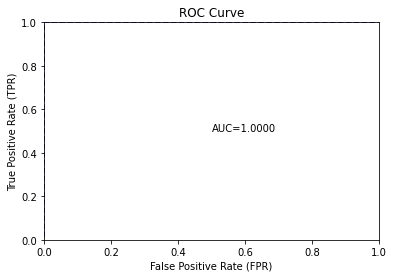

Cross-Validation


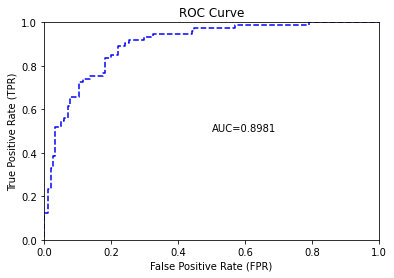

Testing Data


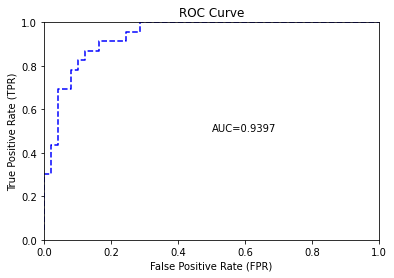

In [97]:
import matplotlib.pyplot as plt
print("Training Data")
gbm_model.model_performance(train = True).plot()
print("Cross-Validation")
gbm_model.model_performance(xval = True).plot()
print("Testing Data")
gbm_model.model_performance(valid = True).plot()

Training Data


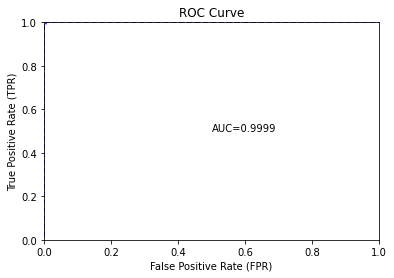

Cross-Validation


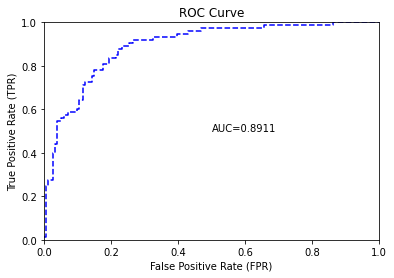

Testing Data


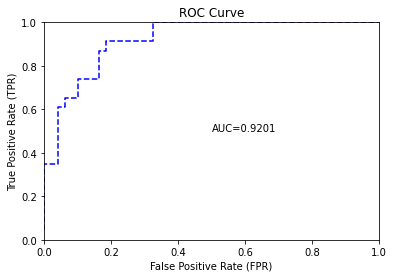

In [100]:
import matplotlib.pyplot as plt
print("Training Data")
gbm_model_.model_performance(train = True).plot()
print("Cross-Validation")
gbm_model_.model_performance(xval = True).plot()
print("Testing Data")
gbm_model_.model_performance(valid = True).plot()

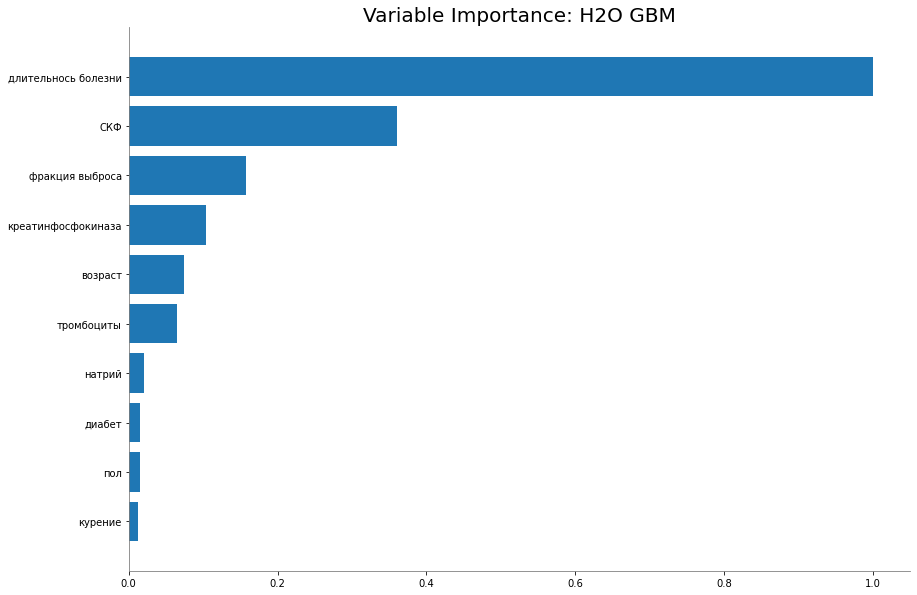

In [98]:
gbm_model.varimp_plot()

In [99]:
from h2o.estimators import H2OXGBoostEstimator

param = {"seed": 1234,
         "nfolds": 5
        }

xgboost_model = H2OXGBoostEstimator(**param)
xgboost_model.train(x = predictors
                    , y = response
                    , training_frame = train
                    , validation_frame = test
                    , model_id = "xgb_default.hex"
                   )

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [22]:
print(xgboost_model)

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  xgb_default.hex


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.003028343445297476
RMSE: 0.05503038656322047
LogLoss: 0.034621292339281975
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7829935550689697: 


,,0,1,Error,Rate
0,0,154.0,0.0,0.0,(0.0/154.0)
1,1,0.0,73.0,0.0,(0.0/73.0)
2,Total,154.0,73.0,0.0,(0.0/227.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.782994,1.000000,72.0
1,max f2,0.782994,1.000000,72.0
2,max f0point5,0.782994,1.000000,72.0
3,max accuracy,0.782994,1.000000,72.0
4,max precision,0.998718,1.000000,0.0
5,max recall,0.782994,1.000000,72.0
6,max specificity,0.998718,1.000000,0.0
7,max absolute_mcc,0.782994,1.000000,72.0
8,max min_per_class_accuracy,0.782994,1.000000,72.0
9,max mean_per_class_accuracy,0.782994,1.000000,72.0



Gains/Lift Table: Avg response rate: 32.16 %, avg score: 32.14 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.013216,0.996129,3.109589,3.109589,1.000000,0.997755,1.000000,0.997755,0.041096,0.041096,210.958904,210.958904,0.041096
1,2,0.022026,0.995506,3.109589,3.109589,1.000000,0.995592,1.000000,0.996890,0.027397,0.068493,210.958904,210.958904,0.068493
2,3,0.030837,0.995199,3.109589,3.109589,1.000000,0.995358,1.000000,0.996452,0.027397,0.095890,210.958904,210.958904,0.095890
3,4,0.044053,0.994444,3.109589,3.109589,1.000000,0.994754,1.000000,0.995943,0.041096,0.136986,210.958904,210.958904,0.136986
4,5,0.052863,0.993103,3.109589,3.109589,1.000000,0.993332,1.000000,0.995507,0.027397,0.164384,210.958904,210.958904,0.164384
5,6,0.101322,0.983573,3.109589,3.109589,1.000000,0.988761,1.000000,0.992281,0.150685,0.315068,210.958904,210.958904,0.315068
6,7,0.149780,0.969747,3.109589,3.109589,1.000000,0.976734,1.000000,0.987251,0.150685,0.465753,210.958904,210.958904,0.465753
7,8,0.202643,0.946944,3.109589,3.109589,1.000000,0.959143,1.000000,0.979918,0.164384,0.630137,210.958904,210.958904,0.630137
8,9,0.299559,0.859163,3.109589,3.109589,1.000000,0.909592,1.000000,0.957166,0.301370,0.931507,210.958904,210.958904,0.931507
9,10,0.400881,0.064215,0.675998,2.494505,0.217391,0.265617,0.802198,0.782379,0.068493,1.000000,-32.400238,149.450549,0.883117




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.0999529500683446
RMSE: 0.3161533647904836
LogLoss: 0.34059705062283435
Mean Per-Class Error: 0.11224489795918369
AUC: 0.9396628216503993
AUCPR: 0.854202496773472
Gini: 0.8793256433007985

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44945210218429565: 


,,0,1,Error,Rate
0,0,40.0,9.0,0.1837,(9.0/49.0)
1,1,1.0,22.0,0.0435,(1.0/23.0)
2,Total,41.0,31.0,0.1389,(10.0/72.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.449452,0.814815,30.0
1,max f2,0.389178,0.912698,33.0
2,max f0point5,0.911117,0.842105,17.0
3,max accuracy,0.911117,0.875000,17.0
4,max precision,0.998494,1.000000,0.0
5,max recall,0.389178,1.000000,33.0
6,max specificity,0.998494,1.000000,0.0
7,max absolute_mcc,0.449452,0.727752,30.0
8,max min_per_class_accuracy,0.570276,0.836735,27.0
9,max mean_per_class_accuracy,0.389178,0.887755,33.0



Gains/Lift Table: Avg response rate: 31.94 %, avg score: 40.00 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.013889,0.997437,3.130435,3.130435,1.000000,0.998494,1.000000,0.998494,0.043478,0.043478,213.043478,213.043478,0.043478
1,2,0.027778,0.996821,3.130435,3.130435,1.000000,0.997005,1.000000,0.997750,0.043478,0.086957,213.043478,213.043478,0.086957
2,3,0.041667,0.996555,3.130435,3.130435,1.000000,0.996565,1.000000,0.997355,0.043478,0.130435,213.043478,213.043478,0.130435
3,4,0.041667,0.996497,0.000000,3.130435,0.000000,0.000000,1.000000,0.997355,0.000000,0.130435,-100.000000,213.043478,0.130435
4,5,0.055556,0.994301,3.130435,3.130435,1.000000,0.996484,1.000000,0.997137,0.043478,0.173913,213.043478,213.043478,0.173913
5,6,0.111111,0.988150,2.347826,2.739130,0.750000,0.990505,0.875000,0.993821,0.130435,0.304348,134.782609,173.913043,0.283940
6,7,0.152778,0.981286,2.086957,2.561265,0.666667,0.987008,0.818182,0.991963,0.086957,0.391304,108.695652,156.126482,0.350488
7,8,0.208333,0.974772,3.130435,2.713043,1.000000,0.977117,0.866667,0.988004,0.173913,0.565217,213.043478,171.304348,0.524401
8,9,0.305556,0.764450,2.236025,2.561265,0.714286,0.879488,0.818182,0.953476,0.217391,0.782609,123.602484,156.126482,0.700976
9,10,0.402778,0.461494,0.894410,2.158921,0.285714,0.605918,0.689655,0.869583,0.086957,0.869565,-10.559006,115.892054,0.685892




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.11986594914590076
RMSE: 0.34621662170655637
LogLoss: 0.40591617074670294
Mean Per-Class Error: 0.16807507560932222
AUC: 0.9031311154598826
AUCPR: 0.8118450427091723
Gini: 0.8062622309197651

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49828362464904785: 


,,0,1,Error,Rate
0,0,139.0,15.0,0.0974,(15.0/154.0)
1,1,19.0,54.0,0.2603,(19.0/73.0)
2,Total,158.0,69.0,0.1498,(34.0/227.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.498284,0.760563,68.0
1,max f2,0.057899,0.847666,114.0
2,max f0point5,0.790382,0.792453,47.0
3,max accuracy,0.498284,0.850220,68.0
4,max precision,0.998850,1.000000,0.0
5,max recall,0.005578,1.000000,181.0
6,max specificity,0.998850,1.000000,0.0
7,max absolute_mcc,0.498284,0.652263,68.0
8,max min_per_class_accuracy,0.247369,0.805195,88.0
9,max mean_per_class_accuracy,0.133757,0.831925,102.0



Gains/Lift Table: Avg response rate: 32.16 %, avg score: 31.45 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.013216,0.997126,3.109589,3.109589,1.000000,0.998198,1.000000,0.998198,0.041096,0.041096,210.958904,210.958904,0.041096
1,2,0.022026,0.994066,3.109589,3.109589,1.000000,0.994636,1.000000,0.996773,0.027397,0.068493,210.958904,210.958904,0.068493
2,3,0.030837,0.993621,1.554795,2.665362,0.500000,0.993789,0.857143,0.995921,0.013699,0.082192,55.479452,166.536204,0.075698
3,4,0.044053,0.992684,3.109589,2.798630,1.000000,0.993266,0.900000,0.995124,0.041096,0.123288,210.958904,179.863014,0.116794
4,5,0.052863,0.987861,3.109589,2.850457,1.000000,0.989170,0.916667,0.994132,0.027397,0.150685,210.958904,185.045662,0.144191
5,6,0.101322,0.969243,2.544209,2.703990,0.818182,0.979459,0.869565,0.987114,0.123288,0.273973,154.420922,170.399047,0.254492
6,7,0.149780,0.933377,3.109589,2.835214,1.000000,0.955685,0.911765,0.976946,0.150685,0.424658,210.958904,183.521354,0.405177
7,8,0.202643,0.831152,2.332192,2.703990,0.750000,0.889741,0.869565,0.954197,0.123288,0.547945,133.219178,170.399047,0.508984
8,9,0.299559,0.499807,1.837484,2.423650,0.590909,0.671050,0.779412,0.862591,0.178082,0.726027,83.748443,142.365028,0.628625
9,10,0.400881,0.209558,0.946397,2.050278,0.304348,0.353747,0.659341,0.733982,0.095890,0.821918,-5.360334,105.027849,0.620619




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.8944849,0.03888801,0.8863636,0.9318182,0.88,0.93333334,0.84090906
1,auc,0.9219782,0.042431396,0.92156863,0.9823529,0.91360295,0.92901236,0.863354
2,aucpr,0.8520177,0.061069246,0.8633215,0.94514686,0.79189926,0.80228436,0.85743654
3,err,0.10551515,0.03888801,0.11363637,0.06818182,0.12,0.06666667,0.1590909
4,err_count,4.8,1.7888544,5.0,3.0,6.0,3.0,7.0
5,f0point5,0.82545453,0.021234596,0.8426966,0.8064516,0.8125,0.85365856,0.8119658
6,f1,0.8414364,0.023478432,0.85714287,0.8695652,0.8125,0.8235294,0.84444445
7,f2,0.86061466,0.05896391,0.872093,0.9433962,0.8125,0.79545456,0.8796296
8,lift_top_group,3.4416947,1.22355,2.5882354,4.4,3.125,5.0,2.0952382
9,logloss,0.4061898,0.17408785,0.37904358,0.19428134,0.40062883,0.3774432,0.679552



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-11-22 12:11:42,5.445 sec,0.0,0.500000,0.693147,0.500000,0.321586,1.000000,0.678414,0.500000,0.693147,0.500000,0.319444,1.000000,0.680556
1,,2020-11-22 12:11:42,5.469 sec,1.0,0.404262,0.516448,0.957659,0.902861,2.897572,0.083700,0.439860,0.577469,0.860692,0.684685,2.347826,0.180556
2,,2020-11-22 12:11:42,5.481 sec,2.0,0.341623,0.411134,0.967577,0.940255,3.018131,0.070485,0.411187,0.520932,0.854037,0.670286,2.347826,0.236111
3,,2020-11-22 12:11:42,5.500 sec,3.0,0.300456,0.343137,0.981498,0.966531,3.109589,0.052863,0.389251,0.476656,0.874002,0.689413,2.347826,0.222222
4,,2020-11-22 12:11:42,5.517 sec,4.0,0.267565,0.289855,0.986479,0.976356,3.109589,0.039648,0.373841,0.444719,0.883762,0.698305,2.347826,0.180556
5,,2020-11-22 12:11:42,5.531 sec,5.0,0.240302,0.247718,0.992484,0.987250,3.109589,0.030837,0.362080,0.421306,0.895741,0.716444,2.347826,0.138889
6,,2020-11-22 12:11:42,5.546 sec,6.0,0.223958,0.219476,0.992884,0.987851,3.109589,0.035242,0.359942,0.412346,0.893523,0.718234,2.347826,0.166667
7,,2020-11-22 12:11:42,5.559 sec,7.0,0.210107,0.196302,0.994574,0.990156,3.109589,0.026432,0.354331,0.399065,0.902396,0.750560,3.130435,0.152778
8,,2020-11-22 12:11:42,5.577 sec,8.0,0.194488,0.173087,0.995908,0.991983,3.109589,0.026432,0.346016,0.381898,0.906832,0.741026,3.130435,0.166667
9,,2020-11-22 12:11:42,5.592 sec,9.0,0.182528,0.156033,0.997687,0.995350,3.109589,0.026432,0.337251,0.369145,0.912156,0.744273,3.130435,0.138889



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,time,242.209320,1.000000,0.486394
1,GFR,100.117043,0.413349,0.201050
2,ejection_fraction,39.296253,0.162241,0.078913
3,creatinine_phosphokinase,33.911060,0.140007,0.068099
4,platelets,29.858883,0.123277,0.059961
5,age,24.662699,0.101824,0.049526
6,serum_sodium,12.773134,0.052736,0.025650
7,sex,8.684384,0.035855,0.017440
8,anaemia,2.442159,0.010083,0.004904
9,diabetes,2.007724,0.008289,0.004032


Training Data


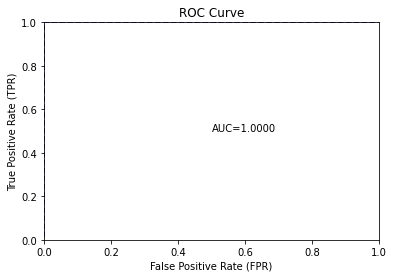

Cross-Validation


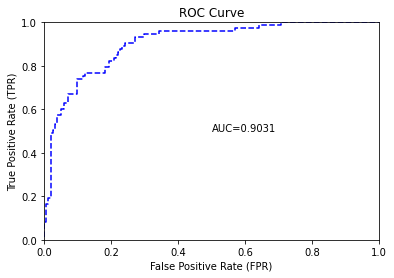

Testing Data


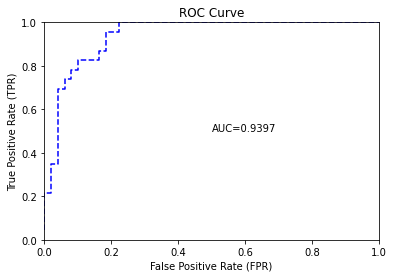

In [23]:
print("Training Data")
xgboost_model.model_performance(train = True).plot()
print("Cross-Validation")
xgboost_model.model_performance(xval = True).plot()
print("Testing Data")
xgboost_model.model_performance(valid = True).plot()

In [24]:
from h2o.grid.grid_search import H2OGridSearch

gbm_params = {'max_depth': [1, 5, 9, 13, 17, 21, 25]
              , 'ntrees': [5000]
              , 'learn_rate': [0.05]
              , 'learn_rate_annealing': [0.99]
              , 'sample_rate': [0.8]
              , 'col_sample_rate': [0.8]
              , 'stopping_metric': 'AUC'
              , 'stopping_rounds': [5]
              , 'stopping_tolerance': [0.001]
             }

gbm_grid = H2OGridSearch(model = H2OGradientBoostingEstimator,
                         hyper_params = gbm_params
                        )

In [25]:
gbm_grid.train(x = predictors, y = response
               , training_frame = train
               , validation_frame = test
               , score_tree_interval = 10
               , seed = 1234
               , grid_id = "gbm_grid"
              )

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [26]:
xgboost_params = {'max_depth': [1, 5, 9, 13, 17, 21, 25]
                  , 'ntrees': [5000]
                  , 'learn_rate': [1, 0.1, 0.01, 0.001]
                  , 'sample_rate': [0.8]
                  , 'col_sample_rate': [0.8]
                  , 'stopping_metric': 'AUC'
                  , 'stopping_rounds': [5]
                  , 'stopping_tolerance': [0.001]
                 }

xgboost_grid = H2OGridSearch(model = H2OXGBoostEstimator
                             , hyper_params = xgboost_params
                            )

In [27]:
xgboost_grid.train(x = predictors, y = response
                   , training_frame = train               
                   , validation_frame = test               
                   , score_tree_interval = 10              
                   , seed = 1234
                   , grid_id = "xgboost_grid"
              )

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


In [28]:
## sort the grid models by decreasing AUC
sorted_gbm_grid = gbm_grid.get_grid(sort_by="auc", decreasing = True)
sorted_gbm_grid

    col_sample_rate  ...         model_ids                 auc
0               0.8  ...  gbm_grid_model_2  0.9361135758651287
1               0.8  ...  gbm_grid_model_3  0.9299023957409052
2               0.8  ...  gbm_grid_model_4  0.9299023957409052
3               0.8  ...  gbm_grid_model_5  0.9299023957409052
4               0.8  ...  gbm_grid_model_6  0.9299023957409052
5               0.8  ...  gbm_grid_model_7  0.9299023957409052
6               0.8  ...  gbm_grid_model_1  0.9281277728482697

[7 rows x 12 columns]


In [29]:
from h2o.estimators import H2ORandomForestEstimator

In [54]:
predictors = ['time','ejection_fraction','GFR','age' ]
# Build and train the model:
r_f_hf = H2ORandomForestEstimator( max_depth=15, seed=1,
                                    validation_frame = test,
                                    binomial_double_trees=True)
r_f_hf.train(x=predictors,
               y=response,
               training_frame=train,
               validation_frame = test
                , model_id = "rf_default.hex")


drf Model Build progress: |███████████████████████████████████████████████| 100%


In [55]:
r_f_hf.model_performance()


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.11201770238974423
RMSE: 0.3346904575719843
LogLoss: 0.895454284723923
Mean Per-Class Error: 0.14138943248532287
AUC: 0.9027308308130226
AUCPR: 0.7881490470825632
Gini: 0.8054616616260453

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2777777777777778: 


,,0,1,Error,Rate
0,0,123.0,31.0,0.2013,(31.0/154.0)
1,1,6.0,67.0,0.0822,(6.0/73.0)
2,Total,129.0,98.0,0.163,(37.0/227.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.277778,0.783626,65.0
1,max f2,0.176471,0.875000,72.0
2,max f0point5,0.550000,0.782609,43.0
3,max accuracy,0.550000,0.854626,43.0
4,max precision,0.950000,0.916667,2.0
5,max recall,0.000000,1.000000,96.0
6,max specificity,1.000000,0.993506,0.0
7,max absolute_mcc,0.277778,0.675672,65.0
8,max min_per_class_accuracy,0.375000,0.837662,57.0
9,max mean_per_class_accuracy,0.238095,0.858611,67.0



Gains/Lift Table: Avg response rate: 32.16 %, avg score: 32.09 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.044053,1.000000,2.798630,2.798630,0.900000,1.000000,0.900000,1.000000,0.123288,0.123288,179.863014,179.863014,0.116794
1,2,0.044053,0.998333,0.000000,2.798630,0.000000,0.000000,0.900000,1.000000,0.000000,0.123288,-100.000000,179.863014,0.116794
2,3,0.052863,0.949211,3.109589,2.850457,1.000000,0.954167,0.916667,0.992361,0.027397,0.150685,210.958904,185.045662,0.144191
3,4,0.101322,0.897500,2.261519,2.568791,0.727273,0.929538,0.826087,0.962315,0.109589,0.260274,126.151930,156.879095,0.234300
4,5,0.149780,0.853361,2.261519,2.469380,0.727273,0.874487,0.794118,0.933900,0.109589,0.369863,126.151930,146.937953,0.324408
5,6,0.207048,0.777778,2.631191,2.514136,0.846154,0.815040,0.808511,0.901024,0.150685,0.520548,163.119073,151.413582,0.462106
6,7,0.299559,0.531053,2.369211,2.469380,0.761905,0.644983,0.794118,0.821952,0.219178,0.739726,136.921070,146.937953,0.648817
7,8,0.400881,0.310577,1.351995,2.186964,0.434783,0.437112,0.703297,0.724685,0.136986,0.876712,35.199524,118.696372,0.701388
8,9,0.502203,0.136364,0.811197,1.909397,0.260870,0.218553,0.614035,0.622571,0.082192,0.958904,-18.880286,90.939678,0.673190
9,10,0.603524,0.050000,0.000000,1.588841,0.000000,0.077729,0.510949,0.531101,0.000000,0.958904,-100.000000,58.884112,0.523839


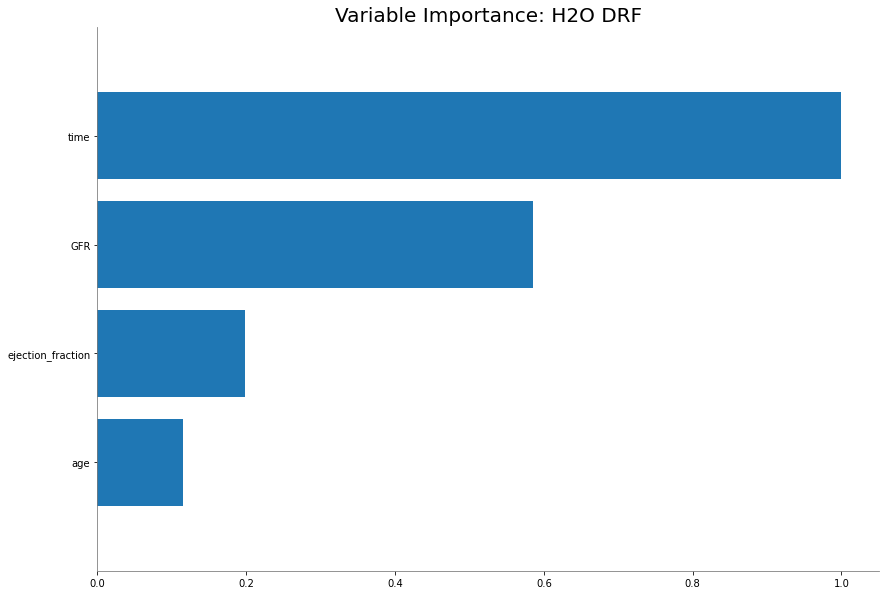

In [51]:
r_f_hf.varimp_plot()

In [45]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(max_models = 6, max_runtime_secs = 120, seed = 12345)
aml.train(x = predictors, y = response, training_frame = train, leaderboard_frame = test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [46]:
lb = aml.leaderboard

In [47]:
lb.head(rows=5)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20201122_123405,0.935226,0.318048,0.848361,0.103372,0.314157,0.0986945
StackedEnsemble_BestOfFamily_AutoML_20201122_123405,0.929015,0.351965,0.825767,0.104703,0.32507,0.105671
StackedEnsemble_AllModels_AutoML_20201122_123405,0.929015,0.354569,0.83079,0.139308,0.327793,0.107448
XGBoost_3_AutoML_20201122_123405,0.921029,0.373687,0.815487,0.12378,0.340704,0.116079
DRF_1_AutoML_20201122_123405,0.915262,0.348554,0.804353,0.137977,0.336068,0.112942


In [48]:
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20201122_123405,0.935226,0.318048,0.848361,0.103372,0.314157,0.0986945
StackedEnsemble_BestOfFamily_AutoML_20201122_123405,0.929015,0.351965,0.825767,0.104703,0.32507,0.105671
StackedEnsemble_AllModels_AutoML_20201122_123405,0.929015,0.354569,0.83079,0.139308,0.327793,0.107448
XGBoost_3_AutoML_20201122_123405,0.921029,0.373687,0.815487,0.12378,0.340704,0.116079
DRF_1_AutoML_20201122_123405,0.915262,0.348554,0.804353,0.137977,0.336068,0.112942
XGBoost_2_AutoML_20201122_123405,0.909494,0.382028,0.774161,0.135315,0.348322,0.121328
GBM_1_AutoML_20201122_123405,0.90772,0.405005,0.825394,0.153061,0.371965,0.138358
GLM_1_AutoML_20201122_123405,0.902396,0.376614,0.791373,0.158385,0.345618,0.119452
